# Cytation 1 and 5

Cytation is a plate reader / imager combination.

See installation instructions [here](installation.md#cytation5-imager).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from pylabrobot.plate_reading import ImageReader, ImagingMode, Objective
from pylabrobot.plate_reading import Cytation5Backend

In [3]:
# for imaging, we need an environment variable to point to the Spinnaker GenTL file
import os
os.environ["SPINNAKER_GENTL64_CTI"] = "/usr/local/lib/spinnaker-gentl/Spinnaker_GenTL.cti"

In [4]:
pr = ImageReader(name="PR", size_x=0,size_y=0,size_z=0, backend=Cytation5Backend())
await pr.setup(use_cam=True)

In [5]:
await pr.backend.get_firmware_version()

'1320200  Version 2.07'

In [6]:
await pr.backend.get_current_temperature()

24.5

In [7]:
await pr.open(slow=False)

Before closing, assign a plate to the plate reader. This determines the spacing of the loading tray in the machine, as well as the positioning of wells where spectrophotometric measurements and pictures will be taken.

In [8]:
from pylabrobot.resources import CellVis_24_wellplate_3600uL_Fb
plate = CellVis_24_wellplate_3600uL_Fb(name="plate")
pr.assign_child_resource(plate)

In [9]:
await pr.close(slow=True)

## Plate reading

Note: these measurements were taken with a 96 well plate.

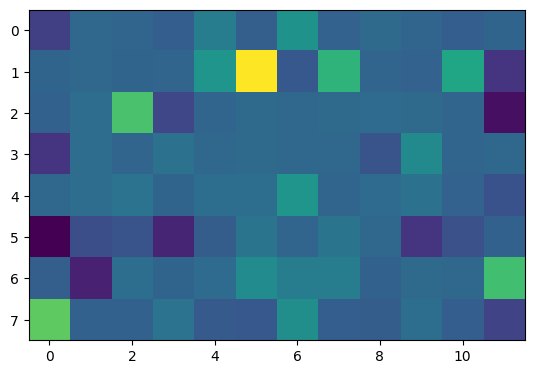

In [10]:
data = await pr.read_absorbance(wavelength=434)
plt.imshow(data)

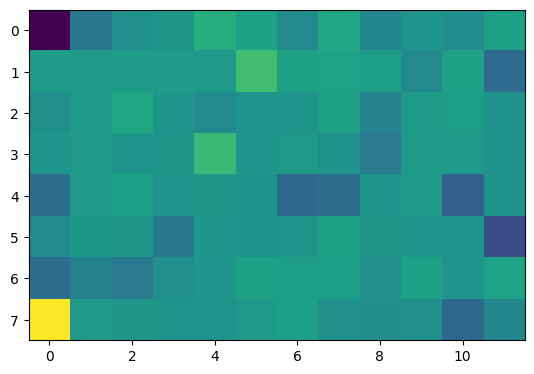

In [11]:
data = await pr.read_fluorescence(
  excitation_wavelength=485, emission_wavelength=528, focal_height=7.5
)
plt.imshow(data)

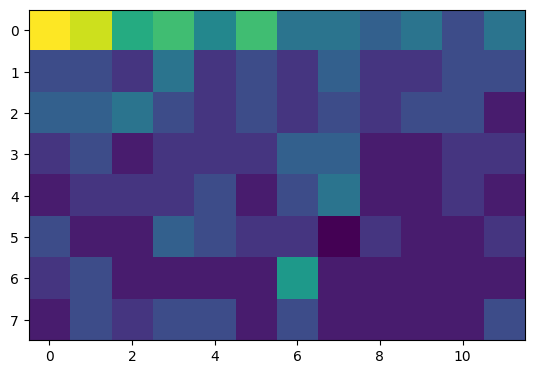

In [12]:
data = await pr.read_luminescence(focal_height=4.5)
plt.imshow(data)

## Shaking

In [10]:
await pr.backend.shake(
  shake_type=Cytation5Backend.ShakeType.LINEAR,
  frequency=4  # linear frequency in mm, 1 <= frequency <= 6
)

In [11]:
await pr.backend.stop_shaking()

## Imaging

### Installation

See [Cytation 5 imager installation instructions](https://docs.pylabrobot.org/user_guide/installation.html#cytation5-imager).

### Usage

Supported objectives:

- `O_4x_PL_FL_PHASE`
- `O_20x_PL_FL_PHASE`
- `O_40x_PL_FL_PHASE`

Supported imaging modes:

- `C377_647`
- `C400_647`
- `C469_593`
- `ACRIDINE_ORANGE`
- `CFP`
- `CFP_FRET_V2`
- `CFP_YFP_FRET`
- `CFP_YFP_FRET_V2`
- `CHLOROPHYLL_A`
- `CY5`
- `CY5_5`
- `CY7`
- `DAPI`
- `GFP`
- `GFP_CY5`
- `OXIDIZED_ROGFP2`
- `PROPOIDIUM_IODIDE`
- `RFP`
- `RFP_CY5`
- `TAG_BFP`
- `TEXAS_RED`
- `YFP`

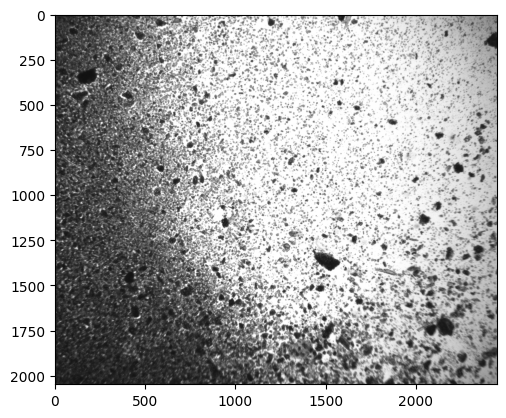

In [10]:
ims = await pr.capture(
  well=(1, 2),
  mode=ImagingMode.BRIGHTFIELD,
  objective=Objective.O_4x_PL_FL_PHASE,
  focal_height=0.833,
  exposure_time=5,
  gain=16,
  led_intensity=10,
)
plt.imshow(ims[0], cmap="gray", vmin=0, vmax=255)

#### Autofocus

Auto-focus can be configured with `pr.backend.set_auto_focus_search_range` where the parameters are the minimum and maximum focus heights in mm respectively.

In [33]:
pr.backend.set_auto_focus_search_range(0.6, 1)

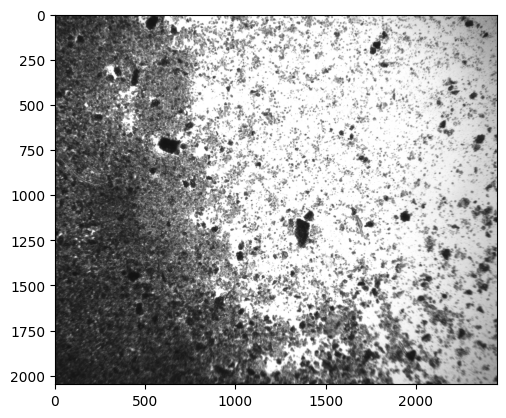

In [41]:
ims = await pr.capture(
  well=(1, 2),
  mode=ImagingMode.BRIGHTFIELD,
  objective=Objective.O_4x_PL_FL_PHASE,
  focal_height="auto", # <----- auto focus
  exposure_time=5,
  gain=16,
  led_intensity=10
)
plt.imshow(ims[0], cmap="gray", vmin=0, vmax=255)

#### Exporting

`.capture` returns a `List[Image]` where `Image = List[List[float]]` where each item is `0 <= x <= 255`. You can export this to an image file in many ways. Here's one example of exporting to a 16-bit tiff:

In [13]:
from PIL import Image
import numpy as np

array = np.array(ims[0], dtype=np.float32)
array_uint16 = (array * (65535 / 255)).astype(np.uint16)
Image.fromarray(array_uint16).save("test.tiff")

#### Coverage

Use the `coverage` parameter to take multiple pictures of the same well. The `coverage` parameter is an tuple `(num_rows, num_columns)` or `"full"`.

When we send the exact same commands as gen5.exe, with overlap = 0, we still get some overlap in the resulting images. This is probably because gen5.exe crops. For now, we don't support stitching or cropping in PLR yet, but we will in the future.

In [31]:
num_rows = 4
num_cols = 4

ims = await pr.capture(
  well=(1, 2),
  mode=ImagingMode.BRIGHTFIELD,
  objective=Objective.O_4x_PL_FL_PHASE,
  focal_height=0.833,
  exposure_time=5,
  gain=16,
  coverage=(num_rows, num_cols),
  center_position=(-6, 0),
)
len(ims)

16

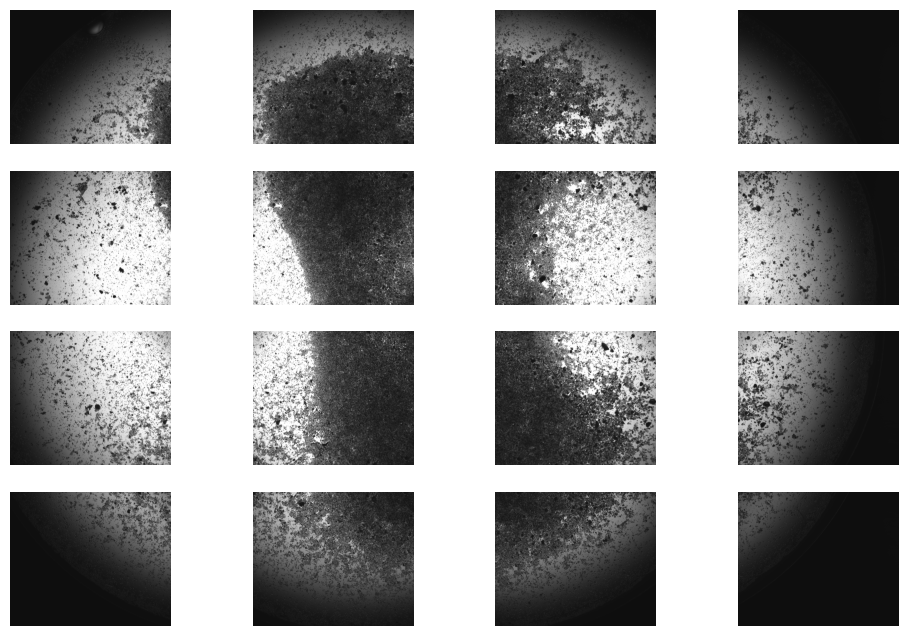

In [30]:
fig = plt.figure(figsize=(12, 8))
for row in range(num_rows):
  for col in range(num_cols):
    plt.subplot(num_rows, num_cols, row * num_cols + col + 1)
    plt.imshow(ims[row * num_cols + col], cmap="gray", vmin=0, vmax=255)
    plt.axis("off")

#### How long does it take to capture an image?

In [19]:
import time
import numpy as np

exposure_time = 1904

# first time setting imaging mode is slower
_ = await pr.capture(well=(1, 1), mode=ImagingMode.BRIGHTFIELD, focal_height=3.3, exposure_time=exposure_time)

l = []
for i in range(10):
  t0 = time.monotonic_ns()
  _ = await pr.capture(well=(1, 1), mode=ImagingMode.BRIGHTFIELD, focal_height=3.3, exposure_time=exposure_time)
  t1 = time.monotonic_ns()
  l.append((t1 - t0) / 1e6)

print(f"{np.mean(l):.2f} ms ± {np.std(l):.2f} ms")
print(f"Overhead: {(np.mean(l) - exposure_time):.2f} ms")

2089.59 ms ± 15.72 ms
Overhead: 185.59 ms
